<a href="https://colab.research.google.com/github/EmmyAcalo/Zindi-Cgiar-/blob/main/Coral_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install the latest version of fastai
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Extracting the files
!unzip "/content/drive/MyDrive/coral_image.zip"

Streaming output truncated to the last 5000 lines.
  inflating: coral_image/ImageID_57I10QK8.jpg  
  inflating: __MACOSX/coral_image/._ImageID_57I10QK8.jpg  
  inflating: coral_image/ImageID_CKA4ZOKX.jpg  
  inflating: __MACOSX/coral_image/._ImageID_CKA4ZOKX.jpg  
  inflating: coral_image/ImageID_Z2BSY7TR.jpg  
  inflating: __MACOSX/coral_image/._ImageID_Z2BSY7TR.jpg  
  inflating: coral_image/ImageID_3KR33EMZ.jpg  
  inflating: __MACOSX/coral_image/._ImageID_3KR33EMZ.jpg  
  inflating: coral_image/ImageID_WTH9HU7X.jpg  
  inflating: __MACOSX/coral_image/._ImageID_WTH9HU7X.jpg  
  inflating: coral_image/ImageID_9E3Y83E6.jpg  
  inflating: __MACOSX/coral_image/._ImageID_9E3Y83E6.jpg  
  inflating: coral_image/ImageID_9LI4WQBM.jpg  
  inflating: __MACOSX/coral_image/._ImageID_9LI4WQBM.jpg  
  inflating: coral_image/ImageID_3ZW7JUXC.jpg  
  inflating: __MACOSX/coral_image/._ImageID_3ZW7JUXC.jpg  
  inflating: coral_image/ImageID_VRWSSZND.jpg  
  inflating: __MACOSX/coral_image/._ImageID_V

In [5]:
#import package needed
from fastai.vision.all import *
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [6]:
#load train data and display
train = pd.read_csv('Train (11).csv')
print(train.shape)
train.head(2)

(21680, 2)


,Image_ID,label
0,ImageID_001G9EFI,Other
1,ImageID_0026LXMN,Hard Coral


In [7]:
#check target labels
train.label.value_counts()

Algae                  11530
Hard Coral              6067
Other                   1571
Soft Coral              1553
Other Invertebrates      959
Name: label, dtype: int64

In [8]:
#load test data and display
test = pd.read_csv('Test (10).csv')
print(test.shape)
test.head(2)

(11963, 1)


,Image_ID
0,ImageID_001KGM1C
1,ImageID_0048JTR3


In [9]:
# load submission file format and display
ss = pd.read_csv('coral_SampleSubmission.csv')
ss.head(2)

,Image_ID,label
0,ImageID_001KGM1C,NaN
1,ImageID_0048JTR3,NaN


In [45]:
#image transform
item_tfms=RandomResizedCrop(128,min_scale=0.5)

In [46]:
#batch transforms
tfms=aug_transforms(mult=2.0,do_flip=True,flip_vert=False)

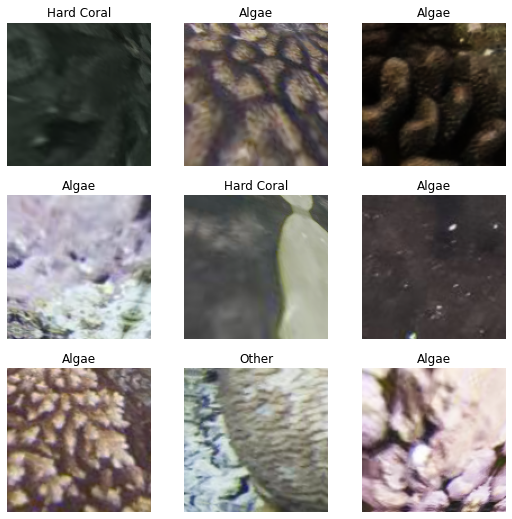

In [47]:
# Create the dataloaders
dls = ImageDataLoaders.from_df(train, path="coral_image", valid_pct=0.2,
                               fn_col='Image_ID', 
                               label_col='label', seed=42,
                               suff='.jpg',item_tfms=item_tfms, num_workers=0,batch_tfms=tfms)
dls.show_batch()

In [31]:
#create a learner
learn = cnn_learner(dls, resnet101, metrics=accuracy)

In [32]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.495195,1.139000,0.576799,03:56


epoch,train_loss,valid_loss,accuracy,time
0,1.174606,1.025768,0.607934,04:56
1,1.081775,0.950486,0.631688,04:56
2,1.002762,0.938099,0.640452,04:56


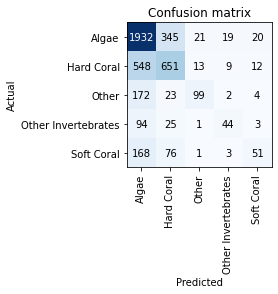

In [33]:
#plot confusion matrix
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

SuggestedLRs(valley=9.999999747378752e-06)

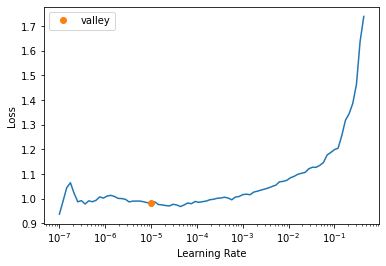

In [34]:
#find learning rate
learn.lr_find()

In [35]:
#find learning rate
#lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [36]:
#lr_min, lr_steep, lr_valley, lr_slide

In [37]:
#finetune more
learn.fine_tune(6,5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.002193,0.945624,0.640913,04:03


epoch,train_loss,valid_loss,accuracy,time
0,0.987925,0.934883,0.641375,04:56
1,0.979442,0.942579,0.643450,04:56
2,0.971832,0.977116,0.639299,04:56
3,0.984054,0.963134,0.641836,04:56
4,0.970253,0.971783,0.642066,04:57
5,0.981902,0.955827,0.642066,04:56


In [38]:
#Get predictions
preds = learn.get_preds(dl=dls.test_dl(test))

In [39]:
preds[0][0], np.argsort(preds[0])[0]

(tensor([0.5341, 0.3467, 0.0158, 0.0482, 0.0552]), tensor([2, 3, 4, 1, 0]))

In [40]:
# The labels in the order used by the model
learn.dls.vocab 

['Algae', 'Hard Coral', 'Other', 'Other Invertebrates', 'Soft Coral']

In [41]:
# the right order
test['label'] = [learn.dls.vocab[p[4]] for p in np.argsort(preds[0])]
test.head()

,Image_ID,label
0,ImageID_001KGM1C,Algae
1,ImageID_0048JTR3,Hard Coral
2,ImageID_00491SIG,Algae
3,ImageID_004B1V2U,Algae
4,ImageID_00C0Q21B,Algae


In [42]:
# Merging them for submission
ss = pd.merge(ss['Image_ID'], test[['Image_ID', 'label']], how='left', on='Image_ID')
ss.head()

,Image_ID,label
0,ImageID_001KGM1C,Algae
1,ImageID_0048JTR3,Hard Coral
2,ImageID_00491SIG,Algae
3,ImageID_004B1V2U,Algae
4,ImageID_00C0Q21B,Algae


In [43]:
#Generate csv file and submit on Zindi
ss.to_csv('Coral_Classification_Submission.csv', index=False)

In [44]:
#pandas version
import fastai
fastai.__version__

'2.5.3'